In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#importing require python classes and packages
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Activation, RepeatVector
from tensorflow.keras.layers import LSTM #class for LSTM training
import os
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Bidirectional #class for bidirectional LSTM as BILSTM to implement as extension
from tensorflow.keras.utils import to_categorical
import seaborn as sns
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pickle

In [3]:
#use to scale or normalize dataset values
normalizer = StandardScaler()

In [30]:
#load and display dataset values
dataset = pd.read_csv("Dataset/Driving_Style.csv")
dataset.fillna(0, inplace = True)
dataset

,angle,angle_speed,AccZ,brake,GyroY,GyroZ,Class,Timestamp
0,0.000000,0.000000,0.000000,0.059407,-0.174707,0.101938,NORMAL,3581629
1,-1.624864,-1.082492,-0.204183,-0.028558,0.051313,0.135536,NORMAL,3581630
2,-0.594660,-0.122410,0.220502,-0.019395,-0.029322,0.087888,NORMAL,3581630
3,0.738478,-0.228456,0.667732,0.069791,-0.029932,0.054902,NORMAL,3581631
4,0.101741,0.777568,-0.066730,0.030696,-0.003665,0.054902,NORMAL,3581631
...,...,...,...,...,...,...,...,...
3639,0.915688,-2.017489,1.687505,0.450360,0.384845,-1.236468,CONSERVATIVE,3583789
3640,-1.934203,0.914925,-0.096013,0.321468,0.649350,-0.477162,CONSERVATIVE,3583790
3641,-0.222845,0.747304,-0.887430,0.361174,-0.406836,0.054291,CONSERVATIVE,3583790
3642,-0.349423,0.067261,0.394368,-0.132405,0.020159,-0.004963,CONSERVATIVE,3583791


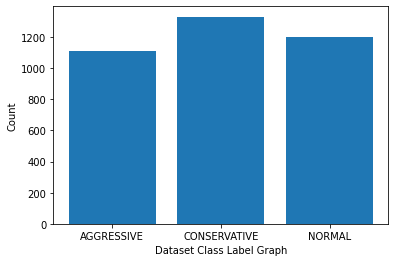

In [31]:
#plot labels in dataset
labels, count = np.unique(dataset['Class'], return_counts = True)
height = count
bars = labels
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Dataset Class Label Graph")
plt.ylabel("Count")
plt.show()

In [32]:
#convert non numeric class label to numeric data using label encoder class
le = LabelEncoder()
dataset['Class'] = pd.Series(le.fit_transform(dataset['Class'].astype(str)))
#now display class label with numeric id
dataset

,angle,angle_speed,AccZ,brake,GyroY,GyroZ,Class,Timestamp
0,0.000000,0.000000,0.000000,0.059407,-0.174707,0.101938,2,3581629
1,-1.624864,-1.082492,-0.204183,-0.028558,0.051313,0.135536,2,3581630
2,-0.594660,-0.122410,0.220502,-0.019395,-0.029322,0.087888,2,3581630
3,0.738478,-0.228456,0.667732,0.069791,-0.029932,0.054902,2,3581631
4,0.101741,0.777568,-0.066730,0.030696,-0.003665,0.054902,2,3581631
...,...,...,...,...,...,...,...,...
3639,0.915688,-2.017489,1.687505,0.450360,0.384845,-1.236468,1,3583789
3640,-1.934203,0.914925,-0.096013,0.321468,0.649350,-0.477162,1,3583790
3641,-0.222845,0.747304,-0.887430,0.361174,-0.406836,0.054291,1,3583790
3642,-0.349423,0.067261,0.394368,-0.132405,0.020159,-0.004963,1,3583791


In [33]:
dataset.columns

Index(['angle', 'angle_speed', 'AccZ', 'brake', 'GyroY', 'GyroZ', 'Class',
       'Timestamp'],
      dtype='object')

In [34]:
#now extract X training features and Y class labels from dataset For Voting Classifier
Y1 = dataset['Class']

X1 = dataset[['angle', 'angle_speed', 'AccZ', 'brake', 'GyroY', 'GyroZ', 'Timestamp']]

In [7]:
#now extract X training features and Y class labels from dataset
Y = dataset['Class'].ravel()
dataset.drop('Class', axis=1, inplace=True)
X = dataset.values
#normalize dataset values for preprocessing
normalizer = StandardScaler()
X = normalizer.fit_transform(X)
print("Normalized Dataset Values")
print(X)
#shuffle dataset values
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
Y = Y[indices]
Y = to_categorical(Y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

Normalized Dataset Values
[[-0.04106156  0.08127915 -0.00839798 ... -1.37441784  0.8125563
  -1.67859727]
 [-1.68980215 -1.11711676 -0.21570562 ...  0.41672656  1.10301486
  -1.67703978]
 [-0.64445974 -0.05423733  0.21547871 ... -0.22227632  0.69109187
  -1.67703978]
 ...
 [-0.26718077  0.90859762 -0.9094098  ... -3.21397144  0.40063334
   1.68713268]
 [-0.39561936  0.15574161  0.39200552 ...  0.16983909 -0.11162986
   1.68869016]
 [-0.44940287  0.53099161 -0.43788106 ... -0.04316186 -0.05881923
   1.68869016]]


In [8]:
#split dataset into train and test where 80% dataset is for training and 20 for testing
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2) #split dataset into train and test
print()
print("Dataset train & test split as 80% dataset for training and 20% for testing")
print("Training Size (80%): "+str(X_train.shape[0])) #print training and test size
print("Testing Size (20%): "+str(X_test.shape[0]))
print()


Dataset train & test split as 80% dataset for training and 20% for testing
Training Size (80%): 2915
Testing Size (20%): 729



In [9]:
#define global variables to calculate and store accuracy and other metrics
precision = []
recall = []
fscore = []
accuracy = []

ML_Model = []
acc = []
prec = []
rec = []
f1 = []

#function to call for storing the results
def storeResults(model, a,b,c,d):
    ML_Model.append(model)
    acc.append(round(a, 3))
    prec.append(round(b, 3))
    rec.append(round(c, 3))
    f1.append(round(d, 3))

In [10]:
#function to calculate various metrics such as accuracy, precision etc
def calculateMetrics(algorithm, predict, testY):
    p = precision_score(testY, predict,average='macro') * 100
    r = recall_score(testY, predict,average='macro') * 100
    f = f1_score(testY, predict,average='macro') * 100
    a = accuracy_score(testY,predict)*100     
    print()
    print(algorithm+' Accuracy  : '+str(a))
    print(algorithm+' Precision   : '+str(p))
    print(algorithm+' Recall      : '+str(r))
    print(algorithm+' FMeasure    : '+str(f))    
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    conf_matrix = confusion_matrix(testY, predict) 
    plt.figure(figsize =(5, 5)) 
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(labels)])
    plt.title(algorithm+" Confusion matrix") 
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()

# CNN


CNN Accuracy  : 97.80521262002743
CNN Precision   : 97.70546837251318
CNN Recall      : 97.83478067715411
CNN FMeasure    : 97.75827199316157


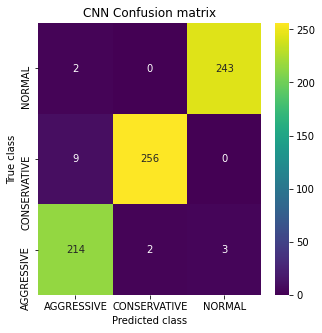

In [11]:
#now train CNN algorithm using two layers CNN and 1 layer maxpooling
cnn_model = Sequential()
#cnn first layer to filter dataset features
cnn_model.add(Conv1D(filters=4, kernel_size = 2, activation = 'relu', input_shape = (X_train.shape[1], X_train.shape[2])))
#cnn second layer
cnn_model.add(Conv1D(filters=3, kernel_size = 2, activation = 'relu'))
#max pool layer to collect relevant features
cnn_model.add(MaxPooling1D(pool_size = 1))
cnn_model.add(Flatten())
#output layer for Y target prediction
cnn_model.add(Dense(units = 16, activation = 'softmax'))
cnn_model.add(Dense(units = y_train.shape[1], activation = 'softmax'))
#compile and train model
cnn_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/cnn_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/cnn_weights.hdf5', verbose = 1, save_best_only = True)
    hist = cnn_model.fit(X_train, y_train, batch_size = 8, epochs = 10, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/cnn_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    cnn_model = load_model("model/cnn_weights.hdf5")
#perform prediction on test data using CNN model   
predict = cnn_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
calculateMetrics("CNN", predict, y_test1)

In [12]:
val_acc = (accuracy_score(predict, y_test1))
val_prec = precision_score(predict, y_test1,average='weighted')
val_rec = recall_score(predict, y_test1,average='weighted')
val_f1 = f1_score(predict, y_test1,average='weighted')

storeResults('CNN',val_acc,val_prec,val_rec,val_f1)

# Propose CNN + LSTM


Propose CNN + LSTM Accuracy  : 97.94238683127571
Propose CNN + LSTM Precision   : 97.86324786324786
Propose CNN + LSTM Recall      : 98.11320754716982
Propose CNN + LSTM FMeasure    : 97.92537345421034


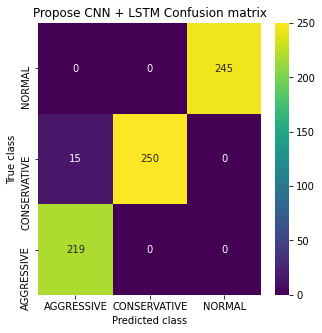

In [13]:
#now define CNN + LSTM model where CNN is used to extarct temporal fetaures and LSTM will perform classification
#on trained temporal features
cnn_lstm_model = Sequential()
#CNN first layers
cnn_lstm_model.add(Conv1D(filters=24, kernel_size = 4, activation = 'relu', input_shape = (X_train.shape[1], X_train.shape[2])))
cnn_lstm_model.add(Conv1D(filters=16, kernel_size = 4, activation = 'relu'))
#max pool layer to collect optimized features from above CONV layer
cnn_lstm_model.add(MaxPooling1D(pool_size = 1))
cnn_lstm_model.add(Flatten())
cnn_lstm_model.add(RepeatVector(2))
#adding LSTM layer for classification using extarcted temporal features
cnn_lstm_model.add(LSTM(32, activation = 'relu'))
cnn_lstm_model.add(Dense(units = 50, activation = 'softmax'))
#define output layer
cnn_lstm_model.add(Dense(units = y_train.shape[1], activation = 'softmax'))
#compile and train model
cnn_lstm_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/cnn_lstm_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/cnn_lstm_weights.hdf5', verbose = 1, save_best_only = True)
    hist = cnn_lstm_model.fit(X_train, y_train, batch_size = 8, epochs = 10, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/cnn_lstm_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    cnn_lstm_model = load_model("model/cnn_lstm_weights.hdf5")
#perform prediction on test data using CNN +LSTM propose model   
predict = cnn_lstm_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
calculateMetrics("Propose CNN + LSTM", predict, y_test1)

In [14]:
val_acc = (accuracy_score(predict, y_test1))
val_prec = precision_score(predict, y_test1,average='weighted')
val_rec = recall_score(predict, y_test1,average='weighted')
val_f1 = f1_score(predict, y_test1,average='weighted')

storeResults('Propose CNN + LSTM',val_acc,val_prec,val_rec,val_f1)

# Extension CNN + LSTM + Bidirectional LSTM


Extension CNN + LSTM + Bidirectional LSTM Accuracy  : 99.86282578875172
Extension CNN + LSTM + Bidirectional LSTM Precision   : 99.84848484848486
Extension CNN + LSTM + Bidirectional LSTM Recall      : 99.87421383647798
Extension CNN + LSTM + Bidirectional LSTM FMeasure    : 99.86105788345799


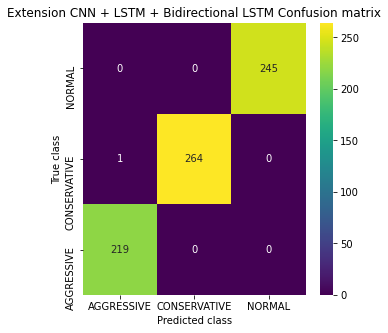

In [15]:
#now define extension model by combining CNN + LSTM + Bidirectional LSTM as this bi-lstm will optimized features from 
#both forward and backward direction so it will have more optimzied features and accuracy will be better
extension_model = Sequential()
#defining CNN layer
extension_model.add(Conv1D(filters=32, kernel_size = 6, activation = 'relu', input_shape = (X_train.shape[1], X_train.shape[2])))
extension_model.add(Conv1D(filters=16, kernel_size = 2, activation = 'relu'))
#adding maxpool layer
extension_model.add(MaxPooling1D(pool_size = 1))
extension_model.add(Flatten())
extension_model.add(RepeatVector(2))
#adding bidirectional + LSTM to CNN layer
extension_model.add(Bidirectional(LSTM(32, activation = 'relu')))
#defining output layer
extension_model.add(Dense(units = 100, activation = 'softmax'))
extension_model.add(Dense(units = y_train.shape[1], activation = 'softmax'))
#compile and train the model
extension_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/extension_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/extension_weights.hdf5', verbose = 1, save_best_only = True)
    hist = extension_model.fit(X_train, y_train, batch_size = 8, epochs = 10, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/extension_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    extension_model = load_model("model/extension_weights.hdf5")
#perform prediction on test data using bidirectional LSTM on test data   
predict = extension_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
calculateMetrics("Extension CNN + LSTM + Bidirectional LSTM", predict, y_test1)

In [16]:
val_acc = (accuracy_score(predict, y_test1))
val_prec = precision_score(predict, y_test1,average='weighted')
val_rec = recall_score(predict, y_test1,average='weighted')
val_f1 = f1_score(predict, y_test1,average='weighted')

storeResults('Extension CNN + LSTM + Bidirectional LSTM',val_acc,val_prec,val_rec,val_f1)

# Voting Classifier

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.2) #split dataset into train and test
print()

In [41]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier

clf1 = BaggingClassifier(RandomForestClassifier(),n_estimators=10, random_state=0)
clf2 = DecisionTreeClassifier(random_state=10)

eclf1 = VotingClassifier(estimators=[('bagging', clf1), ('dt', clf2)], voting='soft')
eclf1.fit(X_train, y_train)
y_pred = eclf1.predict(X_test)

vot_acc = accuracy_score(y_pred, y_test)
vot_prec = precision_score(y_pred, y_test,average='weighted')
vot_rec = recall_score(y_pred, y_test,average='weighted')
vot_f1 = f1_score(y_pred, y_test,average='weighted')


Extension Voting Classifier Accuracy  : 100.0
Extension Voting Classifier Precision   : 100.0
Extension Voting Classifier Recall      : 100.0
Extension Voting Classifier FMeasure    : 100.0


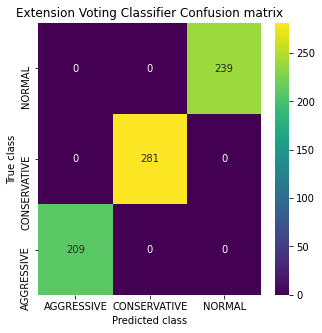

In [53]:
calculateMetrics("Extension Voting Classifier", y_pred, y_test)

In [40]:
storeResults('Voting Classifier',vot_acc,vot_prec,vot_rec,vot_f1)

# Comparison

In [43]:
#creating dataframe
import pandas as pd
import numpy as np
result = pd.DataFrame({ 'ML Model' : ML_Model,
                        'Accuracy' : acc,
                        'f1_score' : f1,
                        'Recall'   : rec,
                        'Precision': prec,
                                                
                      })

In [44]:
result

,ML Model,Accuracy,f1_score,Recall,Precision
0,CNN,0.978,0.978,0.978,0.978
1,Propose CNN + LSTM,0.979,0.979,0.979,0.981
2,Extension CNN + LSTM + Bidirectional LSTM,0.999,0.999,0.999,0.999
3,Voting Classifier,1.000,1.000,1.000,1.000


# Classifier

In [45]:
classifier = ML_Model
y_pos = np.arange(len(classifier))

# Accuracy

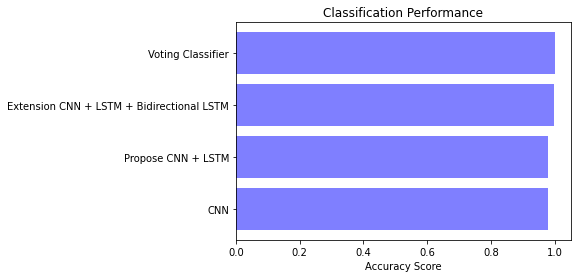

In [46]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, acc, align='center', alpha=0.5,color='blue')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Accuracy Score')
plt2.title('Classification Performance')
plt2.show()

# Preicison

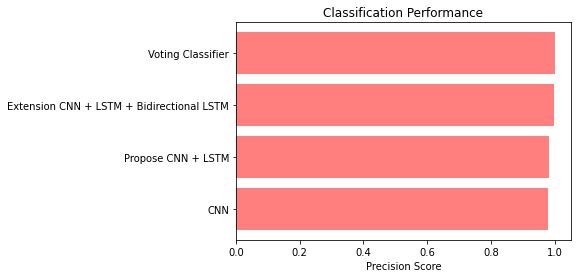

In [47]:
plt2.barh(y_pos, prec, align='center', alpha=0.5,color='red')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Precision Score')
plt2.title('Classification Performance')
plt2.show()

# Recall

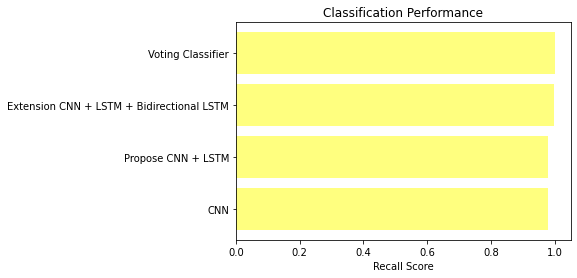

In [48]:
plt2.barh(y_pos, rec, align='center', alpha=0.5,color='yellow')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Recall Score')
plt2.title('Classification Performance')
plt2.show()

# F1 Score

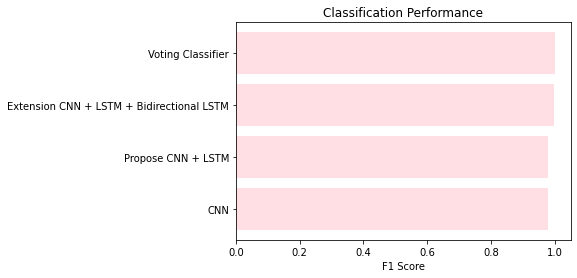

In [49]:
plt2.barh(y_pos, f1, align='center', alpha=0.5,color='pink')
plt2.yticks(y_pos, classifier)
plt2.xlabel('F1 Score')
plt2.title('Classification Performance')
plt2.show()

In [50]:
import joblib
filename = 'model.sav'
joblib.dump(eclf1, filename)

['model.sav']